# Import the relevant Libraries


In [49]:

import numpy as np
import pandas as pd
np.random.seed(42)
import sklearn
import os
#import helper
import keras
import pickle
import math
import collections
import statistics
import random
import csv

from scipy import misc
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.colors
from skimage import data, img_as_float, exposure, io
from skimage import transform as transf
from tqdm import tqdm
from IPython.display import HTML
import cv2
import seaborn as sns


from keras.layers.advanced_activations import LeakyReLU 
from keras import backend as K
from keras.callbacks import CSVLogger, LearningRateScheduler,Callback,ModelCheckpoint,EarlyStopping,TensorBoard,ReduceLROnPlateau
from keras.layers.core import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D, Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.utils import np_utils

from tensorflow.contrib.layers import flatten
from imp import reload


import loader
import preprocess
import plotter
import Models
import class_helper
import params




%matplotlib inline

#SEED = 22



# Load and Explore Data

The three pickled files train.p, test.p, valid.p have been downloaded from the site provided by Udacity https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip

 . X_train, y_train = train['features'], train['labels']
 
 . X_test, y_test = test['features'], test['labels']
 
 . X_val, y_val = valid['features'], valid['labels']


'features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
'labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.

In [3]:
#load data

X_train_orig, y_train_orig, X_test_orig, y_test_orig,X_val_orig,y_val_orig = loader.load_split_input_data()
print("data loaded")


Shapes:
X_train: (39209, 32, 32, 3)
X_test: (12630, 32, 32, 3)
X_valid: (4410, 32, 32, 3)
data loaded


## Basic Stats on data
* Number of training examples = 39209
* Number of validation examples = 4410
* Number of testing examples = 12630
* Image data shape = (32, 32, 3)
* Number of classes = 43

In [4]:
#Print basic stats, number of Train, Test, Valid samples


# Number of training examples
n_train = len(X_train_orig)

# Number of validation examples.
n_validation = len(X_val_orig)

# Number of testing examples.
n_test = len(X_test_orig)

# The shape of a traffic sign image
image_shape = X_train_orig[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.bincount(y_train_orig))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)



Number of training examples = 39209
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
class_stats = loader.get_class_stats(y_train_orig,y_test_orig,y_val_orig)

In [7]:
#utility class functions
def plot_first_images(first_images):
    
    nr = 10 ; nc = 10
    plt.figure(figsize=(nr,nc))
    for image,i in zip(first_images, range(len(first_images))):
        label = (str(i) + "\n"                                            # class
              + '('+str(class_stats['NumTrain'][i])+')')                              # no. of training samples
              
        #plotter.plot_image(image.squeeze(), nr, nc, i+1, label)
        plotter.plot_image(image.squeeze(), nr-3, nc-2, i+1, label)



## Training images, one from each class


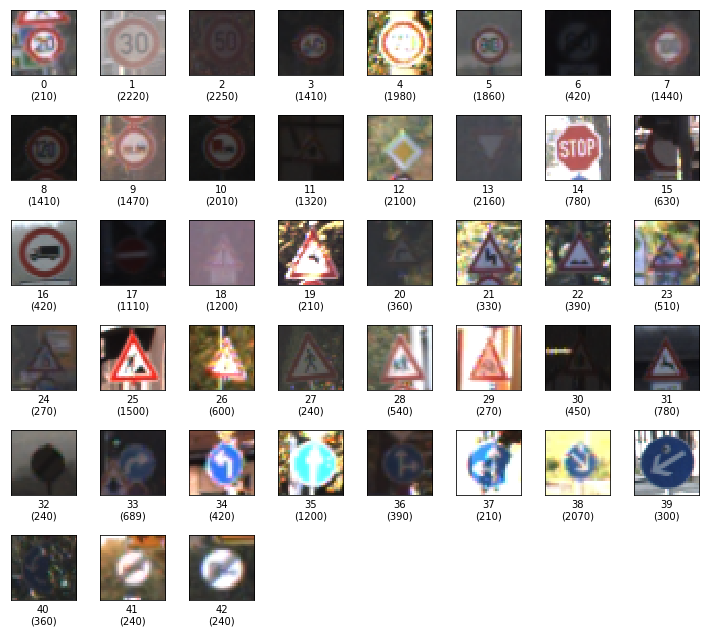

In [8]:
first_imgs = class_helper.get_first_images(X_train_orig,y_train_orig)
plot_first_images(first_imgs)

## Sign Names, counts and percentages of samples per class for Test, Train, Validate datasets

In [9]:
#sign_names=sign_names.round(2)

cm = sns.light_palette("purple", as_cmap=True)
#s = sign_names.style.format({'PerTrain': '{}%', 'PerTrain':'{}%'})
#highlight_max = Styler.highlight_max(subset=None, color='yellow', axis=0)
#format_percent = 
#s = sign_names.style.background_gradient(cmap=cm)

s = class_stats.round(2).copy()
s.columns = ['ClassID','Sign','#Train', '#Test', '#Valid', '%Train','%Test','%Valid']
html = (
    s.style
    .format("{}%", subset=['%Train','%Test','%Valid'])
    #.highlight_max(subset=['NumTrain'])
    .background_gradient(cmap=cm,subset=['#Train','#Test','#Valid','%Train','%Test','%Valid'])
    .render()
)

display(HTML(html))

,ClassID,Sign,#Train,#Test,#Valid,%Train,%Test,%Valid
0,0,Speed limit (20km/h),210,60,30,0.54%,0.48%,0.68%
1,1,Speed limit (30km/h),2220,720,240,5.66%,5.7%,5.44%
2,2,Speed limit (50km/h),2250,750,240,5.74%,5.94%,5.44%
3,3,Speed limit (60km/h),1410,450,150,3.6%,3.56%,3.4%
4,4,Speed limit (70km/h),1980,660,210,5.05%,5.23%,4.76%
5,5,Speed limit (80km/h),1860,630,210,4.74%,4.99%,4.76%
6,6,End of speed limit (80km/h),420,150,60,1.07%,1.19%,1.36%
7,7,Speed limit (100km/h),1440,450,150,3.67%,3.56%,3.4%
8,8,Speed limit (120km/h),1410,450,150,3.6%,3.56%,3.4%
9,9,No passing,1470,480,150,3.75%,3.8%,3.4%


The heated figures and the  heated  markings show unbalanced data amonst classes for all three sets. The unbalance is less of a concern  for test and valid sets, as we dont train on them.

## Visualization 

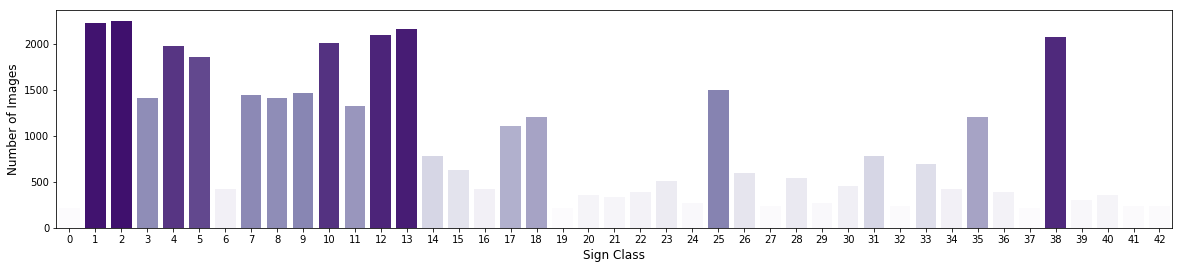

In [10]:
#print(class_stats.head())
plt.figure(figsize=(20,4))
#sns.color_palette("Blues")
#palette=sns.color_palette("Set2", 10)
#palette = sns.color_palette("coolwarm", 7)
norm = plt.Normalize(class_stats['NumTrain'].values.min(), class_stats['NumTrain'].values.max())
palette = plt.cm.Purples(norm(class_stats['NumTrain'])) 
#palette=sns.hls_palette(8, l=.3, s=.8)
sns.barplot(class_stats['ClassId'].values, class_stats['NumTrain'].values,palette=palette)
plt.xlabel('Sign Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.show()

Another way to visualize the distribution, and the unbalanced classes in Training data.

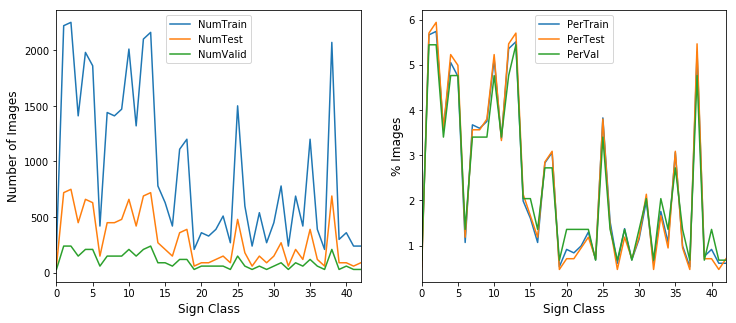

In [11]:



fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)


class_stats.loc[:, 'NumTrain':'NumValid'].plot(ax=ax0)
class_stats.loc[:, 'PerTrain':'PerVal'].plot(ax=ax1)

ax0.set_xlabel('Sign Class', fontsize=12)
ax0.set_ylabel('Number of Images', fontsize=12)

ax1.set_xlabel('Sign Class', fontsize=12)
ax1.set_ylabel('% Images', fontsize=12)



#print(class_stats)


The above plots show that the data is spread out quite proportionally amonst the three sets. The crests and troughs in both the curves  more  or less match.
Test and Train data seem to be more correlated. between classes 19 adn 25, Valid differs  from Test and Train.

The images listed one from each class above show some dark data as well. Lets explore class 11 as the chosen image is very dark.

In [13]:
mean = np.mean(X_train_orig)
std = np.std(X_train_orig)
dark, bright, dark_mean, bright_mean = plotter.get_dark_bright_imgs(class_11_images[:100],mean,std)
print('Number of dark images: '+str(len(dark)))
print('Number of bright images: '+str(len(bright)))


Number of dark images: 52
Number of bright images: 48


### Dark Images from class 11

There are 52 images in the  dataset


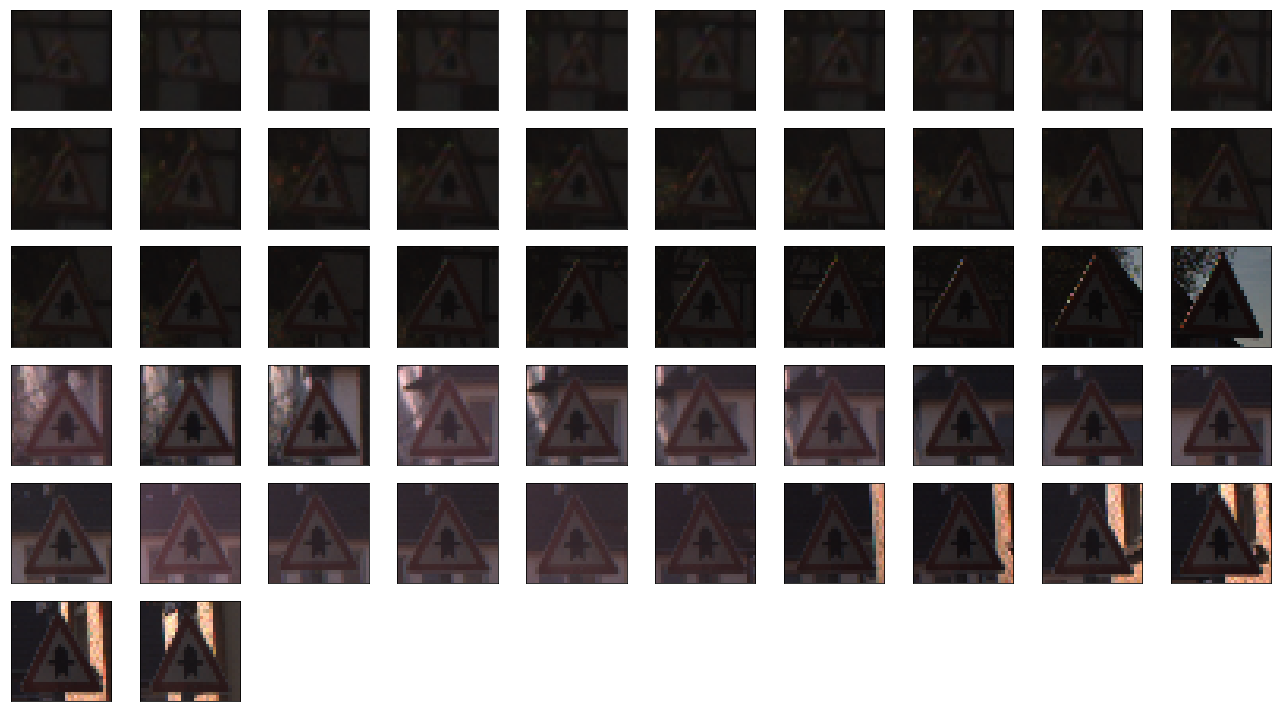

In [14]:

plotter.plot_images(-1,dark,10,"")

### Bright images from class 11

There are 48 images in the  dataset


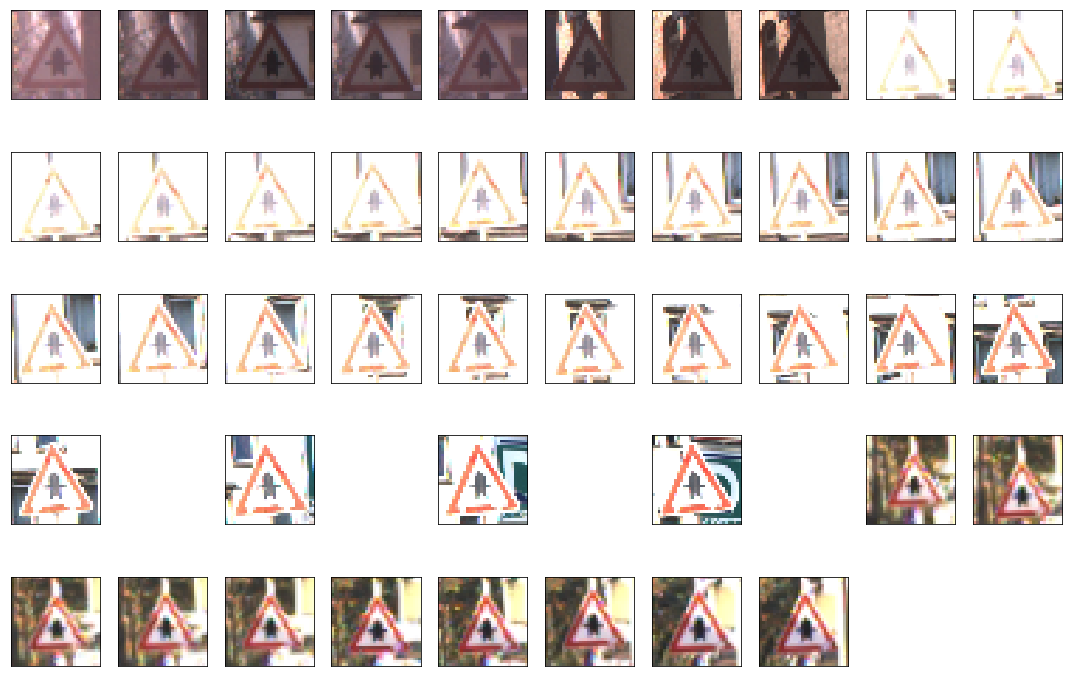

In [15]:
plotter.plot_images(-1,bright,10,"")

Lets see what happens when they are  converted to grayscale. They are  clearer to the human eye.

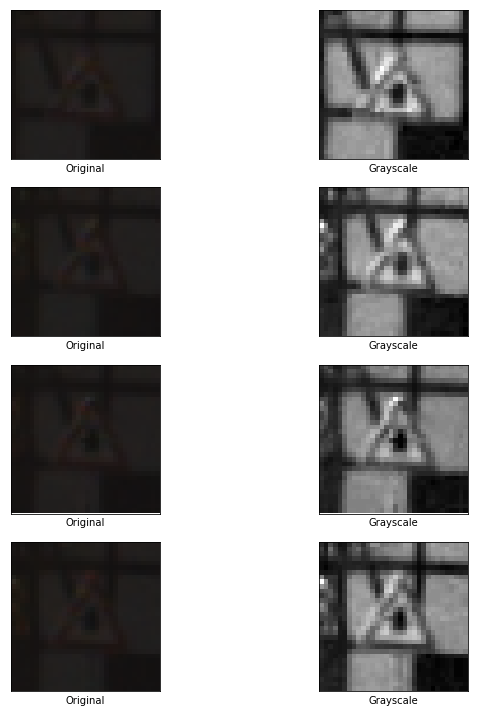

In [19]:
plotter.plot_2_datasets(np.asarray(dark[0:4]), preprocess.conv_to_grayscale_data(np.asarray(dark[0:4])),'Original', 'Grayscale')

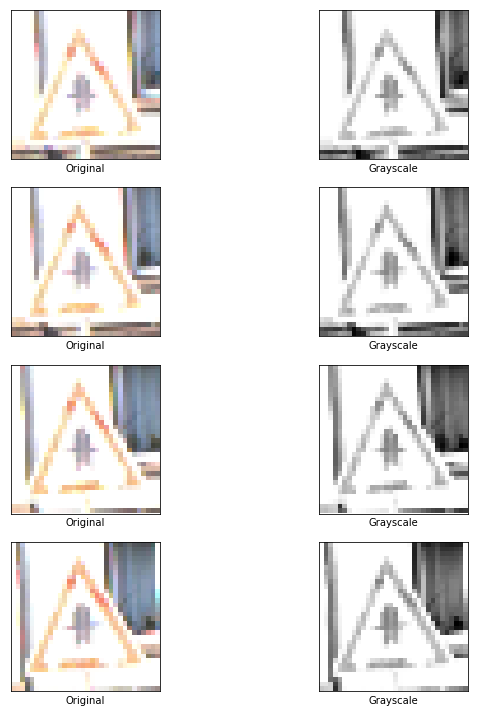

In [20]:
plotter.plot_2_datasets(np.asarray(bright[16:20]), preprocess.conv_to_grayscale_data(np.asarray(bright[16:20])),'Original','Grayscale')


In [21]:
img_dark = dark[0]
img_bright = bright[8]
img_dark_gry = preprocess.conv_to_grayscale_img(img_dark)
img_bright_gry = preprocess.conv_to_grayscale_img(img_bright)

In [22]:
#utility function to help  visualize
def plot_equalize_color_gray(img_dark_equal, img_dark_equal_gry, img_bright_equal, img_bright_equal_gry,op):
    plotter.plot_image(img_dark, 2,4,1, "Original Dark")
    plotter.plot_image(img_dark_equal, 2,4,2,op+" Dark")
    plotter.plot_image(img_dark_gry, 2,4,3, "Original Dark Grey")

    plotter.plot_image(img_dark_equal_gry,2,4,4, op+" Dark Grey")
    plotter.plot_image(img_bright, 2,4,5, "Original Bright")
    plotter.plot_image(img_bright_equal,2,4,6, op+" Bright")
    plotter.plot_image(img_bright_gry, 2,4,7, "Original Bright Grey")

    plotter.plot_image(img_bright_equal_gry,2,4,8, op+" Bright Grey")




### Contrast Stretching 

The grayscale definitely made the image brighter and more decipherable.

Lets use some contrast  enhancing techniques to see how the image is transformed. 

Contrast stretching (often called normalization) is a simple image enhancement technique that attempts to improve thecontrast in an image by `stretching' the range of intensity values it contains to span a desired range of values, e.g. the the full range of pixel values that the image type concerned allows.



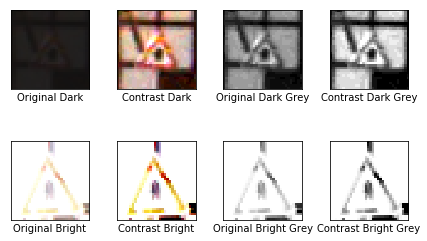

In [23]:
img_dark_contrast = preprocess.contrast_stretch_img(img_dark)
img_bright_contrast = preprocess.contrast_stretch_img(img_bright)
img_dark_contrast_gry = preprocess.contrast_stretch_img(img_dark_gry)
img_bright_contrast_gry = preprocess.contrast_stretch_img(img_bright_gry)


plot_equalize_color_gray(img_dark_contrast,img_dark_contrast_gry,img_bright_contrast,img_bright_contrast_gry,"Contrast")

### Histogram Equalization
Histogram equalization is a method in image processing of contrast adjustment using the image's histogram.  This method usually increases the global contrast of many images, especially when the usable data of the image is represented by close contrast values. Through this adjustment, the intensities can be better distributed on the histogram. This allows for areas of lower local contrast to gain a higher contrast. Histogram equalization accomplishes this by effectively spreading out the most frequent intensity values.


C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\skimage\exposure\exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


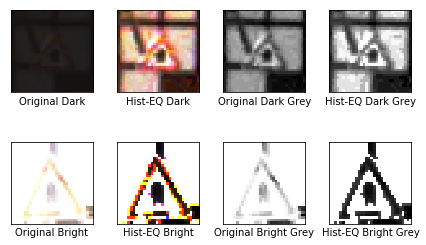

In [24]:
img_dark_hist = preprocess.hist_equalize_img(img_dark)
img_bright_hist = preprocess.hist_equalize_img(img_bright)
img_dark_hist_gry = preprocess.hist_equalize_img(img_dark_gry)
img_bright_hist_gry = preprocess.hist_equalize_img(img_bright_gry)
plot_equalize_color_gray(img_dark_hist,img_dark_hist_gry,img_bright_hist,img_bright_hist_gry,"Hist-EQ")

The image seems higher in contrast than Contrast Stretching


### Adaptive Equalization 
 (AHE) is a computer image processing technique used to improve contrast in images. It differs from ordinary histogram equalizationin the respect that the adaptive method computes several histograms, each corresponding to a distinct section of the image, and uses them to redistribute the lightness values of the image. It is therefore suitable for improving the local contrast and enhancing the definitions of edges in each region of an image.


C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


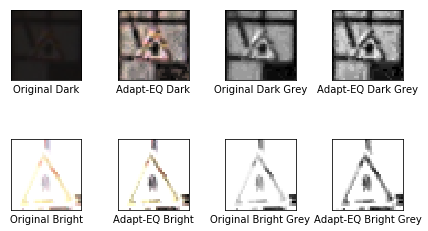

In [25]:
img_dark_adapteq = preprocess.adaptive_equalize_img(img_dark)
img_bright_adapteq = preprocess.adaptive_equalize_img(img_bright)
img_dark_adapteq_gry = preprocess.adaptive_equalize_img(img_dark_gry)
img_bright_adapteq_gry = preprocess.adaptive_equalize_img(img_bright_gry)
plot_equalize_color_gray(img_dark_adapteq,img_dark_adapteq_gry,img_bright_adapteq,img_bright_adapteq_gry,"Adapt-EQ")

Though  not as high in contrast values as Histogram Equalization, this seems to be giving the image  more structure, enhancing  the edges and boundaries

In [26]:
#referenced from 

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box-forced')

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

In [27]:
#### Everything below here is just to create the plot/graphs ####
# Display results
def hist_compare(img, img_contrast, img_hist, img_adapteq):
    fig = plt.figure(figsize=(10, 7)) 
    axes = np.zeros((2, 4), dtype=np.object)
    axes[0, 0] = fig.add_subplot(2, 4, 1)

    for i in range(1, 4):
        axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])

    for i in range(0, 4):
        axes[1, i] = fig.add_subplot(2, 4, 5+i)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('Low contrast image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')

    ax_hist.set_yticks(np.linspace(0, y_max, 5))
    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_contrast, axes[:, 1])
    ax_img.set_title('Contrast stretching')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_hist, axes[:, 2])
    ax_img.set_title('Histogram equalization')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
    ax_img.set_title('Adaptive equalization')
    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()

### Histogram Comparision after the application of Contrast Stretching, Histogram Equalization and Adaptive Equalization
The histograms seem more balanced compared to  the original dark and bright images. Adaptive Equalization seems to be having more of a smooth curve. A combination of these techiques could be used for preprocessing the data.

C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\skimage\exposure\exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


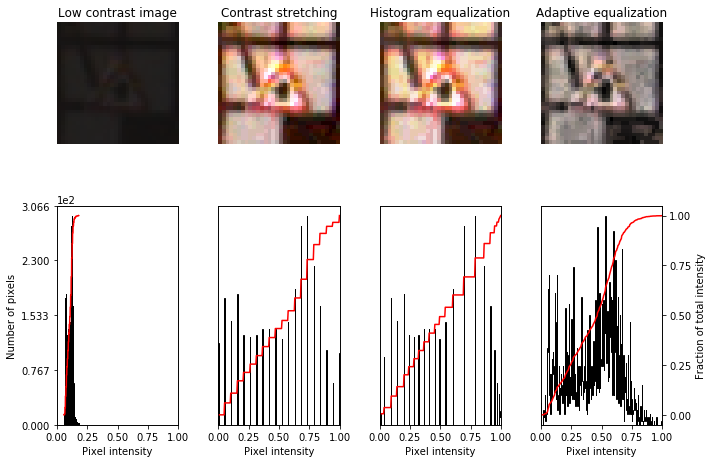

In [28]:
hist_compare(img_dark, img_dark_contrast, img_dark_hist, img_dark_adapteq)


C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\skimage\exposure\exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


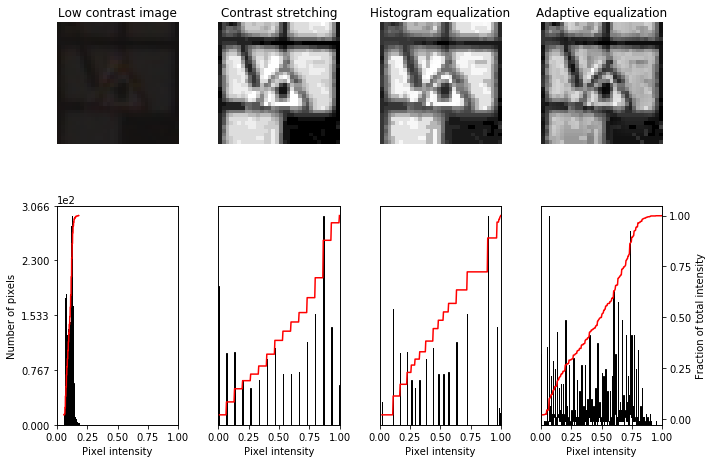

In [29]:
hist_compare(img_dark, img_dark_contrast_gry, img_dark_hist_gry, img_dark_adapteq_gry)


C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\skimage\exposure\exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


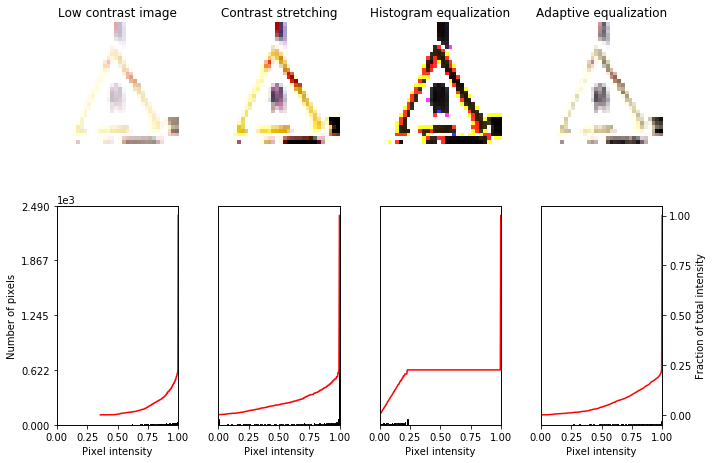

In [30]:
hist_compare(img_bright, img_bright_contrast, img_bright_hist, img_bright_adapteq)


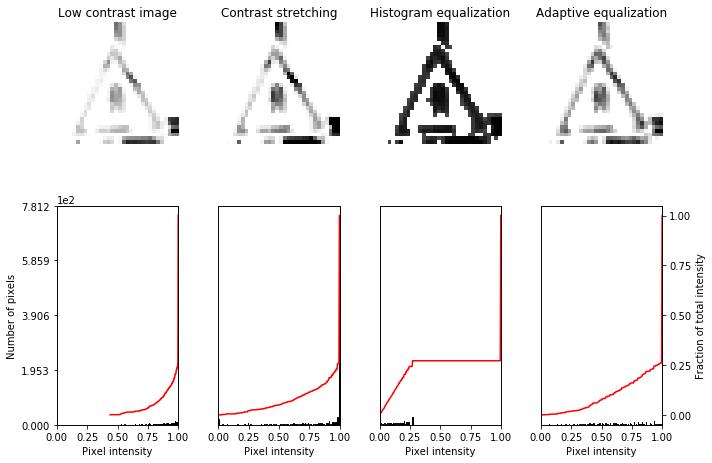

In [31]:
hist_compare(img_bright_gry, img_bright_contrast_gry, img_bright_hist_gry, img_bright_adapteq_gry)


# Preprocess

After several trails, I decided to use the following  preprocessing -
* Apply Grayscale conversion of all sets
* Preprocess Train data

    1. Histogram Equalization 
    2. Supplement Train data with Histogram Equalization + Contrast Stretched (apply both transoformations) versions of the Grayscale.
    3. Further supplement Train data with Histogram Equalization + Adaptive Equalized (apply both transoformations) versions of the Grayscale.
       So the train data now has 3X more times than  its  original quantity.

* Preprocess Valid and Test data

    Histogram Equalization + Adaptive Equalization on the grayscaled version.
    Note, no supplementation. The original  data is transformed.
    

* Data Augment Train data : The transformed data in Train set is further augmented by Data augmentation techniques that shear, rotate, zoom etc teh data. 200 images per class are added.

In [ ]:
X_train,y_train,X_test,y_test,X_val,y_val= preprocess.preprocess_aug_combine_save(X_train_orig,y_train_orig,X_test_orig,y_test_orig,X_val_orig,y_val_orig)

#clear unused variables
del X_train_orig
del y_train_orig
del X_test_orig
del y_test_orig
del X_val_orig
del y_val_orig

In [32]:


X_train,y_train,X_test,y_test,X_val,y_val=loader.load_combine_preprocessed("hae")




Loading data ...
preprocessed\preprocessed_hset_aug_gray.p
X_aug_all:  8600
y_aug_all:  8600
Data and modules loaded.
preprocessed\preprocessed_hist_gray.p
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
Data and modules loaded.
preprocessed\preprocessed_hae_gray.p
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
Data and modules loaded.
preprocessed\preprocessed_hcs_gray.p
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
Data and modules loaded.
combining dataset 0 of type <class 'numpy.ndarray'> and length 8600
combining dataset 1 of type <class 'numpy.ndarray'> and length 34799
combining dataset 2 of type <class 'numpy.ndarray'> and length 34799
combining dataset 3 of type <class 'numpy.ndarray'> and length 34799
length of combined set : 112997


"when using the categorical_crossentropy loss, your targets should be in categorical format (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros expect for a 1 at the index corresponding to the class of the sample). In order to convert integer targets into categorical targets, you can use the Keras utility to_categorical:" [Keras documentation]

In [33]:
#one hot  encoding of y series


y_train_e= np_utils.to_categorical(y_train,num_classes=params.n_classes)
y_val_e = np_utils.to_categorical(y_val,num_classes=params.n_classes)
y_test_e = np_utils.to_categorical(y_test,num_classes=params.n_classes)





## Model 

* As can be seen below, the model has 4 convolution layers and 2 fully connected layers, the last one being the output layer that is used to classify the features extracted by the convolutional  layers.

* The total number of trainable parameters are  1,438,225 and their splits are provided in each layer below.

* I use Batch  Normalization, dropout to regulate the data, Maxpool to generalize and reduce the number of parameters

* The learnable module Spatial Transformer Network si used to provide spatial invariance learning. Unlike the static data augmentation, this provides for dynamic learnt transformations, that its localization network learns  to predict. It is a differentiable module and hence subject to standard back propagation which facilitates its learning of the 6 parameters that define a transformation.


In [80]:
m = Models.deep_cnn_model()
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_transformer_6 (Spati (None, 32, 32, 1)         501542    
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_26 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 64)        18496     
__________

### Train Model

Parameters:
    
    * LR : 001 (combinations of static, reduce-on-plateau(loss), schedudled reduce )
    
    * STN : with and without STN
    
    * epochs : 20
    
   



In [39]:
def save_model_history(label,model_dir,history) :
    suffix='.log'
    
    filename = os.path.join(model_dir,'history_'+label+suffix)
    
    with open(filename, 'wb') as f:
        pickle.dump(history, f)
    print("History saved in file "+filename)
    

import tensorflow as tf
class LearningRateTracker(Callback):
    def __init__(self,model):
        
        self.model = model
        
    def on_epoch_end(self, epoch, logs={}):
        
        # _lr = K.get_value(tf.to_float(model.optimizer.lr, name='ToFloat'))
        # _decay = tf.to_float(model.optimizer.decay, name='ToFloat')
        #_iter = tf.to_float(model.optimizer.iterations, name='ToFloat')
        
        lr = K.get_value(self.model.optimizer.lr)
        
        print("\nCurrent learning rate: "+str(lr))

                    
def train_model_(model,label,flag_earlystop=True,flag_reduceLR=True, flag_lrsched=False,flag_tensorboard=True):
    
    batch_size=512
    epochs=20
    
    #cwd =os.getcwd()
    #print("CWD: "+str(cwd))
    #model_dir = os.path.join(cwd,params.model_dir,label)
    model_dir = os.path.join(params.model_dir,label)
    print(model_dir)
    if not os.path.exists(model_dir):
        try:
            print("create new dir")
            os.makedirs(model_dir)
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                print("error making directory")
                raise

    else:
        print("dir exists")
    
    # Compile and train the model
    suffix = '.hdf5'
    weights_file = os.path.join(model_dir,'weights_'+label+suffix)
    print("weights file: "+weights_file)
    
    adam = Adam()
    callbacks=[]
    if (flag_tensorboard==True):
        tensorboard=TensorBoard(log_dir=model_dir, histogram_freq=0, batch_size=batch_size, write_graph=True)
        callbacks.append(tensorboard)

    if (flag_earlystop == True):
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5 , verbose=2, mode='auto')
        callbacks.append(early_stop)
        
    if (flag_reduceLR == True):
        flag_lrsched=False
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.000001)
        callbacks.append(reduce_lr)

    #lr =  K.get_value(model.optimizer.lr)
    
    
    
    #lr = 0.0001
    if (flag_lrsched == True):
        lr = 0.001
       
        adam=Adam(lr=lr)
        def lr_schedule(epoch):
            #print("-----------------------------epoch : "+str(epoch))
            #print (lr*(0.1 ** int(epoch / 4)))
            return lr * ( 0.5 ** int(epoch / 5))

        lr_sched = LearningRateScheduler(lr_schedule)
        callbacks.append(lr_sched)
    
    model.compile(loss='categorical_crossentropy',
          optimizer=adam,
          metrics=['accuracy'])
    print("starting LR:"+str(K.get_value(model.optimizer.lr)))
    trackLR = LearningRateTracker(model)
    
    csv_logger = CSVLogger(os.path.join(model_dir,'training.log'), append=True)
    checkpointer = ModelCheckpoint(filepath=weights_file, verbose=2, save_best_only=True, save_weights_only=True)
    callbacks.append(csv_logger)
    callbacks.append(checkpointer)
    callbacks.append(trackLR)
    
    print("CALLBACKS : "+str(callbacks))
    try:

        history = model.fit(X_train, y_train_e,
                    batch_size=batch_size, epochs=epochs,
                    #callbacks=[checkpointer,early_stop,lr_sched],
                    callbacks=callbacks,
                    #shuffle=False,
                    verbose=1, validation_data=(X_val, y_val_e))

    except KeyboardInterrupt:
        print("training interrupted")

    #print(history.history)
    evaluate = model.evaluate(X_test,y_test_e)
    print("---------------------------------------")
    print(evaluate)
    try:
        save_model_history(label,model_dir,history.history)
        
    except OSError as exc: 
        return  history.history, evaluate
    return history.history,evaluate

### Train Model without the  STN componet

In [9]:
model = Models.deep_cnn_model(flag_BN=True,flag_STN=False)
history,evaluate= train_model_(model,"BN_No_STN",flag_earlystop=False,flag_reduceLR=False, flag_lrsched=False,flag_tensorboard=True)


CWD: /home/carnd/KerasTrafficSignClassifier
/home/carnd/KerasTrafficSignClassifier/model/BN_No_STN
/home/carnd/KerasTrafficSignClassifier/model/BN_No_STN/weights_BN_No_STN.hdf5
starting LR:0.001
CALLBACKS : [<keras.callbacks.TensorBoard object at 0x7f1c52fc1ac8>, <keras.callbacks.CSVLogger object at 0x7f1c52fe5358>, <keras.callbacks.ModelCheckpoint object at 0x7f1c52fe5d30>, <__main__.LearningRateTracker object at 0x7f1c52fe5828>]
Train on 112997 samples, validate on 4410 samples
Epoch 1/20
112640/112997 [============================>.] - ETA: 0s - loss: 1.3172 - acc: 0.6293Epoch 00000: val_loss improved from inf to 3.42156, saving model to /home/carnd/KerasTrafficSignClassifier/model/BN_No_STN/weights_BN_No_STN.hdf5

Current learning rate: 0.001
112997/112997 [==============================] - 61s - loss: 1.3147 - acc: 0.6301 - val_loss: 3.4216 - val_acc: 0.1181
Epoch 2/20
112640/112997 [============================>.] - ETA: 0s - loss: 0.3432 - acc: 0.8931Epoch 00001: val_loss improv

### Train Model with STN, with static learning rate of 0.001

* Train Accuracy : 99.54 
* Valid Accuracy : 99.27

In [13]:
model2 = Models.deep_cnn_model(flag_BN=True,flag_STN=True)
history2,evaluate2= train_model_(model2,"BN_STN_001",flag_earlystop=False,flag_reduceLR=False, flag_lrsched=False,flag_tensorboard=True)


CWD: /home/carnd/KerasTrafficSignClassifier
/home/carnd/KerasTrafficSignClassifier/model/BN_STN_001
/home/carnd/KerasTrafficSignClassifier/model/BN_STN_001/weights_BN_STN_001.hdf5
starting LR:0.001
CALLBACKS : [<keras.callbacks.TensorBoard object at 0x7f1c2a7db198>, <keras.callbacks.CSVLogger object at 0x7f1c2a7fc048>, <keras.callbacks.ModelCheckpoint object at 0x7f1c2a7fc4e0>, <__main__.LearningRateTracker object at 0x7f1c2a7fc390>]
Train on 112997 samples, validate on 4410 samples
Epoch 1/20
112640/112997 [============================>.] - ETA: 0s - loss: 1.0738 - acc: 0.7060Epoch 00000: val_loss improved from inf to 2.18488, saving model to /home/carnd/KerasTrafficSignClassifier/model/BN_STN_001/weights_BN_STN_001.hdf5

Current learning rate: 0.001
112997/112997 [==============================] - 77s - loss: 1.0711 - acc: 0.7067 - val_loss: 2.1849 - val_acc: 0.2095
Epoch 2/20
112640/112997 [============================>.] - ETA: 0s - loss: 0.1725 - acc: 0.9513Epoch 00001: val_loss i

### Train model, reduce LR when loss plateaus 

* Train Accuracy : 99.81
* Valid Accuracy : 99.57
* reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.000001)
    
    patience: if the monitor(val_loss) remains the same for 3 epochs, reduce the LR by a factor of 0.5.
    
    min_lr : The lr must  not be less than  min_lr at any given time.

In [40]:
model3 = Models.deep_cnn_model(flag_BN=True,flag_STN=True)
history3,evaluate3= train_model_(model3,"BN_STN_reduceLR",flag_earlystop=False,flag_reduceLR=True, flag_lrsched=False,flag_tensorboard=True)


model/BN_STN_reduceLR
create new dir
weights file: model/BN_STN_reduceLR/weights_BN_STN_reduceLR.hdf5
starting LR:0.001
CALLBACKS : [<keras.callbacks.TensorBoard object at 0x7f555340c9b0>, <keras.callbacks.ReduceLROnPlateau object at 0x7f555340c828>, <keras.callbacks.CSVLogger object at 0x7f555342ce10>, <keras.callbacks.ModelCheckpoint object at 0x7f55533d3c88>, <__main__.LearningRateTracker object at 0x7f555342cef0>]
Train on 112997 samples, validate on 4410 samples
Epoch 1/20
112640/112997 [============================>.] - ETA: 0s - loss: 1.1153 - acc: 0.6997Epoch 00000: val_loss improved from inf to 1.62021, saving model to model/BN_STN_reduceLR/weights_BN_STN_reduceLR.hdf5

Current learning rate: 0.001
112997/112997 [==============================] - 76s - loss: 1.1125 - acc: 0.7004 - val_loss: 1.6202 - val_acc: 0.4839
Epoch 2/20
112640/112997 [============================>.] - ETA: 0s - loss: 0.1758 - acc: 0.9506Epoch 00001: val_loss improved from 1.62021 to 0.13469, saving model

### Train Model with scheduled LR drops

lr = (lr*(0.1 ** int(epoch / 4)))
           
* Train Accuracy : 99.52 
* Valid Accuracy : 99.57

In [30]:
model4 = Models.deep_cnn_model(flag_BN=True,flag_STN=True)
history4,evaluate4= train_model_(model4,"BN_STN_lrsched",flag_earlystop=False,flag_reduceLR=False, flag_lrsched=True,flag_tensorboard=True)


model/BN_STN_lrsched
create new dir
weights file: model/BN_STN_lrsched/weights_BN_STN_lrsched.hdf5
starting LR:0.001
CALLBACKS : [<keras.callbacks.TensorBoard object at 0x7f5584212fd0>, <keras.callbacks.LearningRateScheduler object at 0x7f5584212860>, <keras.callbacks.CSVLogger object at 0x7f55841c8cc0>, <keras.callbacks.ModelCheckpoint object at 0x7f55841db208>, <__main__.LearningRateTracker object at 0x7f55841c8908>]
Train on 112997 samples, validate on 4410 samples
Epoch 1/20
112640/112997 [============================>.] - ETA: 0s - loss: 1.0596 - acc: 0.7131Epoch 00000: val_loss improved from inf to 1.84895, saving model to model/BN_STN_lrsched/weights_BN_STN_lrsched.hdf5

Current learning rate: 0.001
112997/112997 [==============================] - 75s - loss: 1.0574 - acc: 0.7137 - val_loss: 1.8489 - val_acc: 0.3478
Epoch 2/20
112640/112997 [============================>.] - ETA: 0s - loss: 0.1651 - acc: 0.9541Epoch 00001: val_loss improved from 1.84895 to 0.09453, saving model 

### Train  Model with scheduled LR Drops 

 return lr * ( 0.5 ** int(epoch / 5))

* Train Accuracy = 99.87
* Valid Accuracy = 99.57



In [38]:
model5 = Models.deep_cnn_model(flag_BN=True,flag_STN=True)
history5,evaluate5= train_model_(model5,"BN_STN_lrsched_2",flag_earlystop=False,flag_reduceLR=False, flag_lrsched=True,flag_tensorboard=True)


model/BN_STN_lrsched_2
create new dir
weights file: model/BN_STN_lrsched_2/weights_BN_STN_lrsched_2.hdf5
starting LR:0.001
CALLBACKS : [<keras.callbacks.TensorBoard object at 0x7f5558f8c390>, <keras.callbacks.LearningRateScheduler object at 0x7f5558f8c208>, <keras.callbacks.CSVLogger object at 0x7f5558f04b70>, <keras.callbacks.ModelCheckpoint object at 0x7f5558f2b7b8>, <__main__.LearningRateTracker object at 0x7f5558f04c88>]
Train on 112997 samples, validate on 4410 samples
Epoch 1/20
112640/112997 [============================>.] - ETA: 0s - loss: 1.1156 - acc: 0.6992Epoch 00000: val_loss improved from inf to 2.43752, saving model to model/BN_STN_lrsched_2/weights_BN_STN_lrsched_2.hdf5

Current learning rate: 0.001
112997/112997 [==============================] - 76s - loss: 1.1129 - acc: 0.6999 - val_loss: 2.4375 - val_acc: 0.1887
Epoch 2/20
112640/112997 [============================>.] - ETA: 0s - loss: 0.1723 - acc: 0.9523Epoch 00001: val_loss improved from 2.43752 to 0.25603, sav

## Visualize Output from Spatial transformer Network (epoch 1)
The object of interest is zoomed it. It also appears a little sheared.

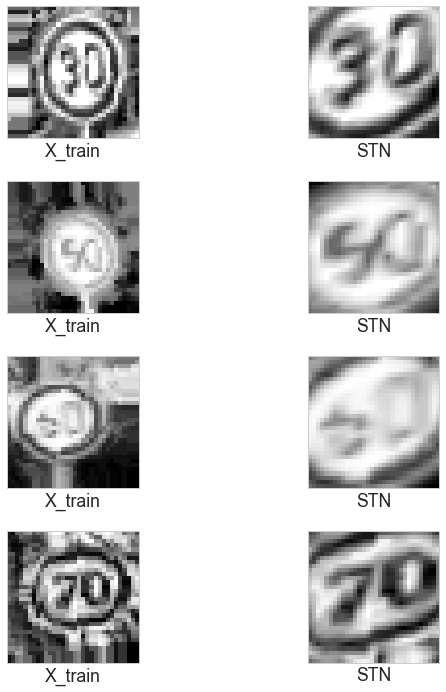

In [110]:
import keras.backend as K
x = model.input
y = model.layers[0].output
funct = K.function([x], [y])
first_imgs = class_helper.get_first_images(X_train,y_train)

Xresult = funct([first_imgs[1:5]])
plotter.plot_2_datasets(first_imgs[1:5],np.asarray(Xresult).squeeze(),"X_train","STN")

###  Visualize Output from the Convolutions 

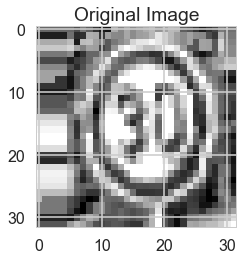

Transformations in Convolution Layer 0


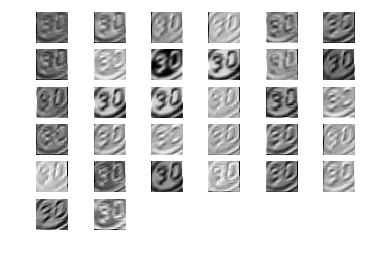

Transformations in Convolution Layer 1


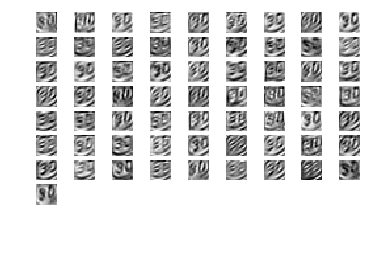

Transformations in Convolution Layer 2


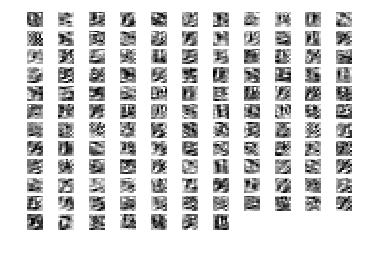

Transformations in Convolution Layer 3


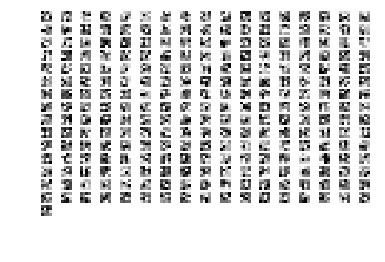

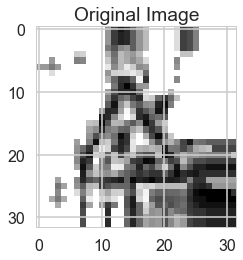

Transformations in Convolution Layer 0


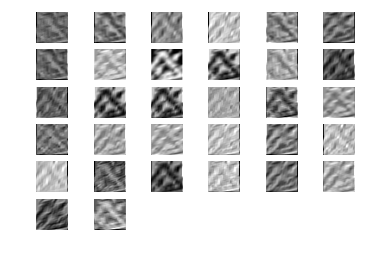

Transformations in Convolution Layer 1


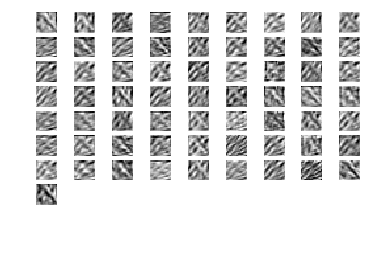

Transformations in Convolution Layer 2


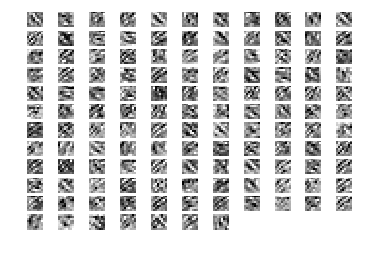

Transformations in Convolution Layer 3


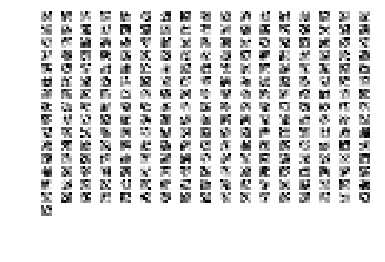

In [112]:
import matplotlib.pyplot as plt
# Get the convolutional layers
conv2d_layers = [layer for layer in model.layers if isinstance(layer, Convolution2D)]
# select two images
img_indices = np.asarray([1,25])
sel_imgs = first_imgs[img_indices]

# keras function 
conv_funct = K.function([model.layers[0].input, K.learning_phase()], [layer.output for layer in conv2d_layers])
imgs_layers_outputs = conv_funct([sel_imgs, 0])

for img_no in range(len(img_indices)):
    plt.title("Original Image")
    plt.imshow(sel_imgs[img_no].squeeze(), cmap='gray')
    plt.tight_layout()
    plt.show()

    for conv_no, layer_outputs in enumerate(imgs_layers_outputs):
        layer_outputs_for_img = layer_outputs[img_no]
        print("Transformations in Convolution Layer %d" % conv_no)
        figures = [layer_outputs_for_img[:, :, output] for output in range(layer_outputs_for_img.shape[-1])]
        dims = plotter.get_dim(len(figures))
        plotter.plot_figures(figures, dims)


## TEST  all models on Test Data

[Loss, Accuracy]
1. Model with Static LR : 0.001 : [0.078798514442264503, 0.97885985750106241]

2. Model with Reduce on Plateau LR : [0.055269072866941486, 0.98495645293713752]

3. Model with Scheduled LR reduce : [0.058489322348336321, 0.982897862279972]

4. Model with Scheduled LR reduce : [0.060815478878839174, 0.98440221699097752]


The model with Reduce on Plateau LR did the best on the test set.



In [87]:

#load models
from keras.models import load_model
import Models 

def load_model(label):
    print("loading model ")
    #label = "BN_STN_001_reduceLR"
    weights_file = os.path.join(params.model_dir,label,"weights_"+label+".hdf5")
    print(weights_file)
    #weights_file="weights_deep_cnn_98.hdf5"
    model = Models.deep_cnn_model(flag_BN=True,flag_STN=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])


    model.load_weights(weights_file)
    return model

model2 = load_model("BN_STN_001")

model3 = load_model("BN_STN_reduceLR")

model4 = load_model("BN_STN_lrsched")

model5 = load_model("BN_STN_lrsched_2")

print("Evaluating")
#load the best model 
evaluate2= model2.evaluate(X_test,y_test_e,verbose=False)
print(evaluate2)

evaluate3= model3.evaluate(X_test,y_test_e,verbose=False)
print(evaluate3)

evaluate4= model4.evaluate(X_test,y_test_e,verbose=False)
print(evaluate4)

evaluate5= model5.evaluate(X_test,y_test_e,verbose=False)
print(evaluate5)


#prob = model.predict(X_test)
#predictions = np.argmax(prob, axis=1)
#print(predictions)
print("Done")


loading model 
model\BN_STN_001\weights_BN_STN_001.hdf5
loading model 
model\BN_STN_reduceLR\weights_BN_STN_reduceLR.hdf5
loading model 
model\BN_STN_lrsched\weights_BN_STN_lrsched.hdf5
loading model 
model\BN_STN_lrsched_2\weights_BN_STN_lrsched_2.hdf5
Evaluating
[0.078798514442264503, 0.97885985750106241]
[0.055269072866941486, 0.98495645293713752]
[0.058489322348336321, 0.982897862279972]
[0.060815478878839174, 0.98440221699097752]
Done


## Training Accuracy, Loss Plots

### Compare the top two models 
* "BN_STN_lrsched_2"
* "BN_STN_reduceLR"

We find  that the curves are very similar.

model\BN_STN_lrsched_2\history_BN_STN_lrsched_2.log
model\BN_STN_reduceLR\history_BN_STN_reduceLR.log


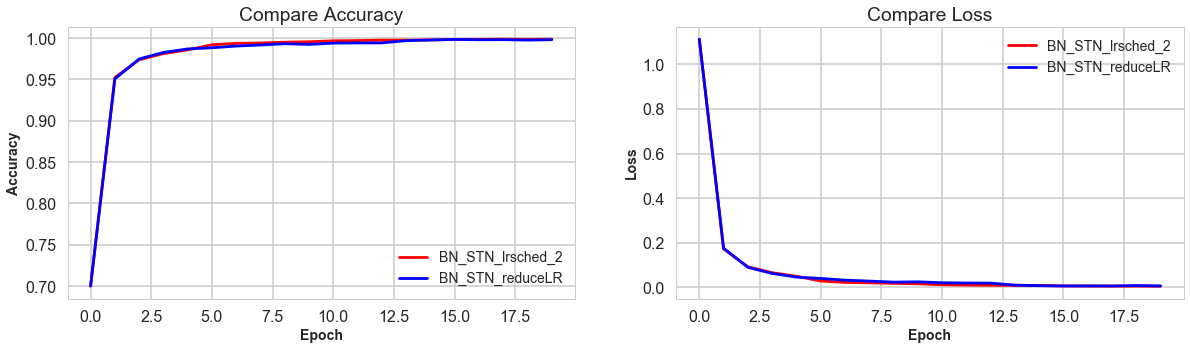

In [88]:
plotter=reload(plotter)
label = "BN_STN_lrsched_2"
suffix = '.log'
no_stn_his_f = os.path.join(params.model_dir,label,'history_'+label+suffix)
print(no_stn_his_f)

file = open(no_stn_his_f,'rb')
history1 = pickle.load(file)
file.close()
#print(model_history)
#plotter.plot_train_loss_accuracy(model_history)


label = "BN_STN_reduceLR"
suffix = '.log'
no_stn_his_f = os.path.join(params.model_dir,label,'history_'+label+suffix)
print(no_stn_his_f)

file = open(no_stn_his_f,'rb')
history2 = pickle.load(file)
file.close()


plotter.compare_train_loss_accuracy(history1, history2, "BN_STN_lrsched_2","BN_STN_reduceLR")

### Training  Curves for  Loss and Accuracey for Validation set and the Train set for the top performing  model

We find a steep learning curve by epoch 3.  

In one  of the trials I used a smaller starting LR 0.0001. The learning was more gradual than the following curve, but by epoch 20, the accuracy was lower than compared to the following.

I could experiment with greater number of epochs (maybe 50-100) and smaller starting LR, that could decay further. Limited  resources constrained me from doing  that.



model\BN_STN_reduceLR\history_BN_STN_reduceLR.log


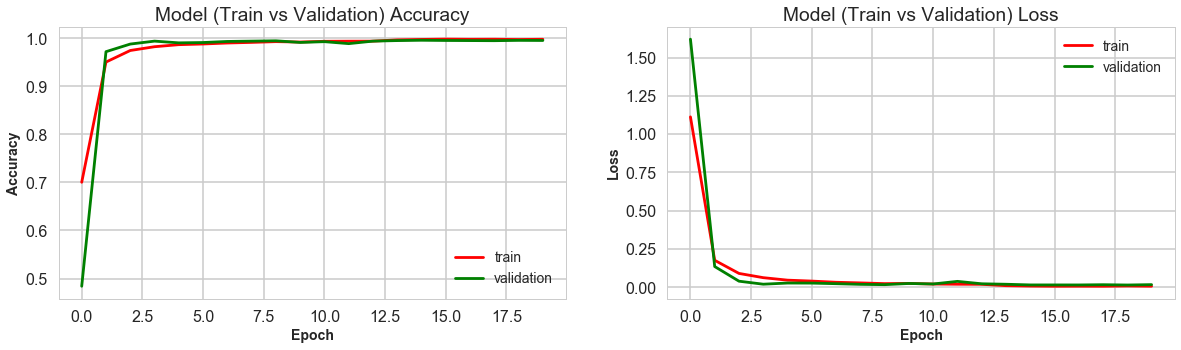

In [89]:
label = "BN_STN_reduceLR"
suffix = '.log'
hisf = os.path.join(params.model_dir,label,'history_'+label+suffix)
print(hisf)

file = open(hisf,'rb')
his = pickle.load(file)
file.close()
#print(model_history)
plotter.plot_train_loss_accuracy(his)


The  above graph shows almost equivalent curves for  Valid and Train from epoch 1 onwards.

There is an  indication of quick learning.

There is no variance.

There is a little  bias given the long plateau.

### Preprocess

# Evaluate the test results of the best model 

Best Model  :  Reduce on Plateau



### Probability distribution and predictions of the best model

In [45]:


#model_deep= load_model('deep_cnn_89_all_aug_on_hae.h5',custom_objects={'STN':SpatialTransformer})
#load the best model 

model = model3
evaluate= evaluate3
prob = model.predict(X_test)
predictions = np.argmax(prob, axis=1)
#print(predictions)
print("Done")


loading model 
model\BN_STN_reduceLR\weights_BN_STN_reduceLR.hdf5
Evaluating


In [91]:
print("Model loss, Model Accuracy on test data")
print(evaluate)

Model loss, Model Accuracy on test data
[0.055269072866941486, 0.98495645293713752]


### Error Stats

In [50]:
error_indices = np.where(predictions!=y_test)[0]
#print(error_indices)
numErrors = error_indices.shape[0]
print ("No of wrong predictions: ", numErrors)
error_classes = [y_test[i] for i in error_indices]
df_error_truth = pd.DataFrame.from_dict(collections.Counter(error_classes), orient='index')
#print(df_error_truth)

#print((df_errors).shape)
df_error_truth = df_error_truth.rename(columns={0:'Errors'})
#print(df_errors)

class_stats['Errors'] = df_error_truth['Errors']
class_stats.fillna(value=0, inplace=True)
class_stats['Error%'] = ((class_stats['Errors']/class_stats['NumTest'])*100).round(2)
class_stats['Error%Train'] = ((class_stats['Errors']/class_stats['NumTrain'])*100).round(2)


No of wrong predictions:  190


In [93]:
#### Errors per class and Error percentages per class

In [51]:
cm = sns.light_palette("purple", as_cmap=True)
#s = sign_names.style.format({'PerTrain': '{}%', 'PerTrain':'{}%'})
#highlight_max = Styler.highlight_max(subset=None, color='yellow', axis=0)
#format_percent = 
#s = sign_names.style.background_gradient(cmap=cm)

s = (class_stats[['ClassId','SignName','NumTrain','NumTest','NumValid','Errors','Error%','Error%Train']].
round(2).copy())
s.columns = ['ClassID','Sign','#Train', '#Test', '#Valid','Errors','%Error','%Error(Train)']
html = (
    s.style
    .format("{}%", subset=['%Error','%Error(Train)'])
    #.highlight_max(subset=['NumTrain'])
    .background_gradient(cmap=cm,subset=['#Train','#Test','#Valid','Errors','%Error','%Error(Train)'])
    .render()
)

display(HTML(html))
del html
del s


,ClassID,Sign,#Train,#Test,#Valid,Errors,%Error,%Error(Train)
0,0,Speed limit (20km/h),210,60,30,0,0.0%,0.0%
1,1,Speed limit (30km/h),2220,720,240,2,0.28%,0.09%
2,2,Speed limit (50km/h),2250,750,240,1,0.13%,0.04%
3,3,Speed limit (60km/h),1410,450,150,20,4.44%,1.42%
4,4,Speed limit (70km/h),1980,660,210,5,0.76%,0.25%
5,5,Speed limit (80km/h),1860,630,210,3,0.48%,0.16%
6,6,End of speed limit (80km/h),420,150,60,14,9.33%,3.33%
7,7,Speed limit (100km/h),1440,450,150,0,0.0%,0.0%
8,8,Speed limit (120km/h),1410,450,150,21,4.67%,1.49%
9,9,No passing,1470,480,150,0,0.0%,0.0%


Class 42 has the highest percentage of errors.

In [95]:
#### Visualize Error Distributions

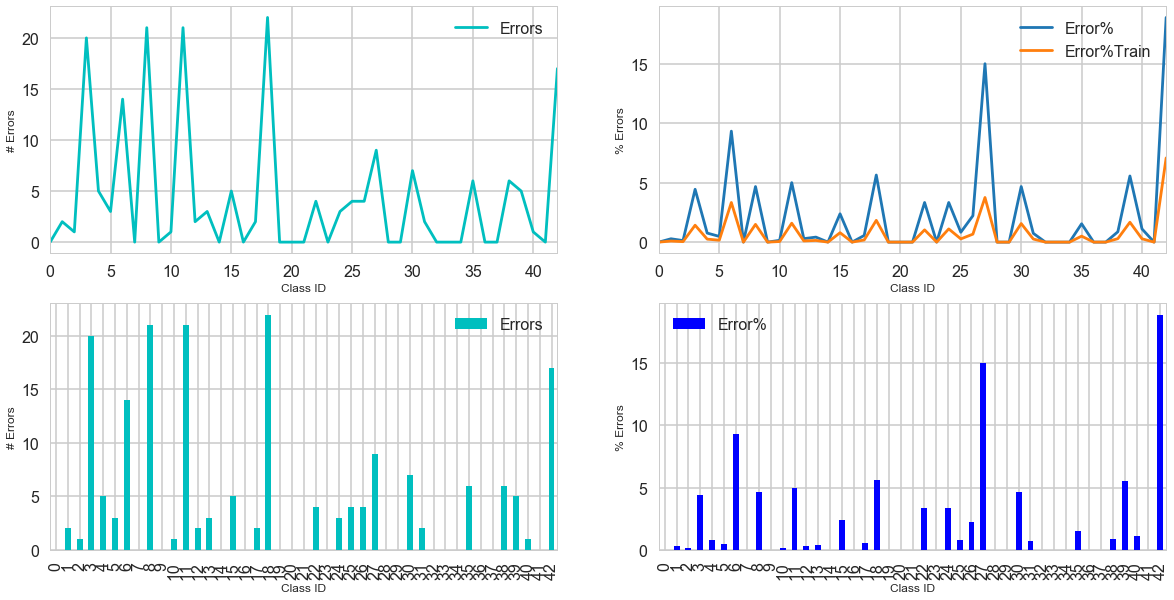

In [52]:
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(ncols=2,nrows=2,figsize=(20, 10), sharey=False)


class_stats[['Errors']].plot(ax=ax2,kind='bar',color = 'c')
class_stats[['Error%']].plot(ax=ax3,kind='bar',color = 'b')
class_stats[['Errors']].plot(ax=ax0,kind='line',color = 'c')
class_stats[['Error%','Error%Train']].plot(ax=ax1,kind='line')


ax0.set_xlabel('Class ID', fontsize=12)
ax0.set_ylabel('# Errors', fontsize=12)

ax1.set_xlabel('Class ID', fontsize=12)
ax1.set_ylabel('% Errors', fontsize=12)


ax2.set_xlabel('Class ID', fontsize=12)
ax2.set_ylabel('# Errors', fontsize=12)

ax3.set_xlabel('Class ID', fontsize=12)
ax3.set_ylabel('% Errors', fontsize=12)

#### Confusion Matrix of  Predictions

Given  the  98% accuracy, most of the predictions are  right, the diagonal stands out.



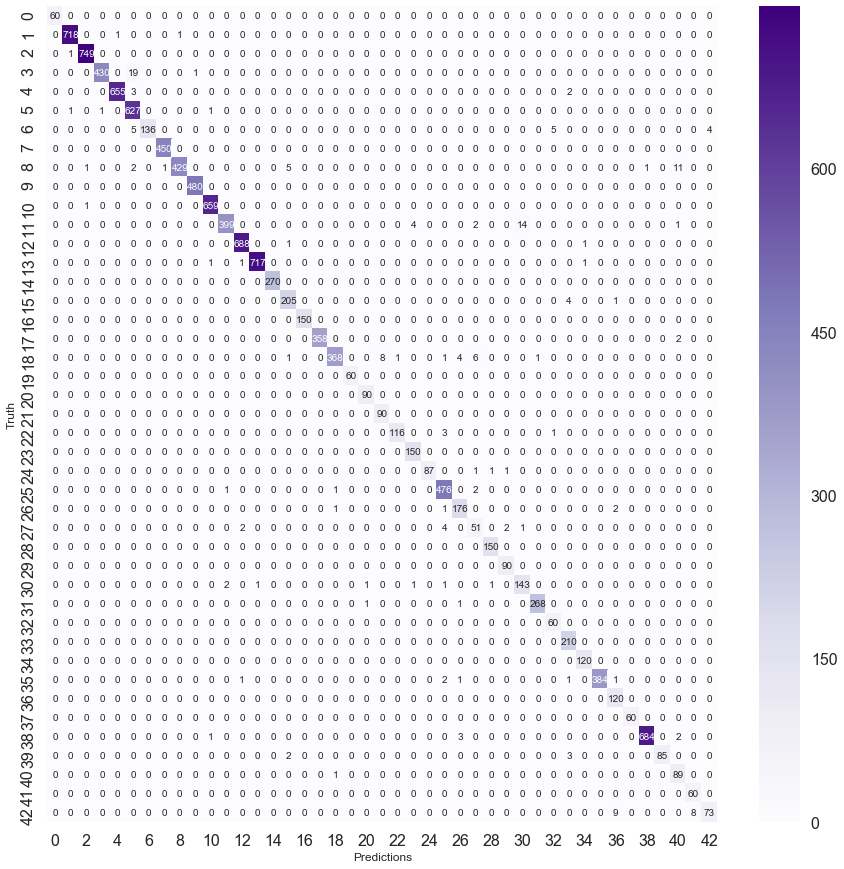

In [53]:

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches




palette = sns.color_palette('Purples')

cm = confusion_matrix(y_test, predictions)
#colormap = ListedColormap(palette.as_hex())

#cm = cm.pivot("Truth", "Predictions", "Errors")
ax = sns.heatmap(cm,annot=True, fmt="d", ax=ax,cmap="Purples")
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Truth', fontsize=12)
plt.show()

#### Confusion Matrix  without the correct predictions

Class 42 h as been almost equally misclassified as Class 36 adn class 42


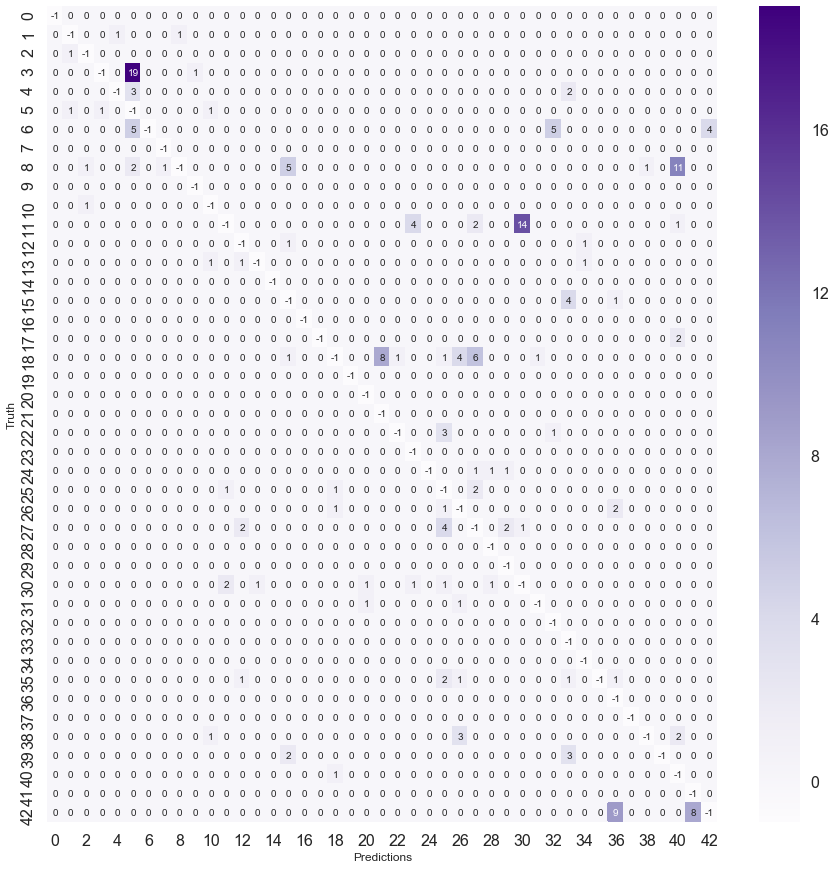

In [54]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches

palette = sns.color_palette('Purples')

cm = confusion_matrix(y_test, predictions)
#colormap = ListedColormap(palette.as_hex())


np.fill_diagonal(cm,-1)

ax = sns.heatmap(cm,annot=True, fmt="d", ax=ax,cmap="Purples")
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Truth', fontsize=12)
plt.show()

In [98]:
#df = sklearn.metrics.classification_report( labels=None, target_names=None, sample_weight=None, digits=2)
df1 = sklearn.metrics.precision_recall_fscore_support(y_test, predictions, labels=None, average=None,  sample_weight=None)
class_stats["F1"] = df1[2]
class_stats["Precision"] = df1[0]
#print(class_stats)

np.fill_diagonal(cm,0)


max_misclassified_class =  np.argmax(cm, axis=1)
#replace accurate classes with 'NA'
max_misclassified_class_errors =  np.amax(cm, axis=1)
#print(max_misclassified_class_errors)
per=np.zeros(n_classes)
for i in range(n_classes):

    if (max_misclassified_class_errors[i] == 0):

        max_misclassified_class[i]= -1
        per[i]= np.nan
    else:
        per[i]=(max_misclassified_class_errors[i]/(class_stats.iloc[i]["NumTest"]-class_stats.iloc[i]["Errors"]))*100

class_stats["Max_Misclassified_as"]=max_misclassified_class
class_stats["Max_Misclassified_Class_%"] = per


####  Classes, their Class prediciton Accuracy, Precision, Maximum Misclassified as class, and the misclassification percentage of the misclassified class.

In [75]:



s = (class_stats[["SignName","F1","Precision","Max_Misclassified_as","Max_Misclassified_Class_%"]]
.round(2).copy())
s.columns = ['Sign','Accuracy(F1)', 'Precision', 'Max Misclassified as','%Max_Misclassified_Class']
html = (
    s.style
    .format("{}%", subset=['%Max_Misclassified_Class'])
    #.highlight_max(subset=['NumTrain'])
    .background_gradient(cmap="Purples",subset=['%Max_Misclassified_Class'])
    .render()
)

display(HTML(html))
del html
del s





C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


,Sign,Accuracy(F1),Precision,Max Misclassified as,%Max_Misclassified_Class
0,Speed limit (20km/h),1,1,-1,nan%
1,Speed limit (30km/h),1,1,4,0.14%
2,Speed limit (50km/h),1,1,1,0.13%
3,Speed limit (60km/h),0.98,1,5,4.42%
4,Speed limit (70km/h),1,1,5,0.46%
5,Speed limit (80km/h),0.98,0.96,1,0.16%
6,End of speed limit (80km/h),0.95,1,5,3.68%
7,Speed limit (100km/h),1,1,-1,nan%
8,Speed limit (120km/h),0.98,1,40,2.56%
9,No passing,1,1,-1,nan%


We see some of the more  missclassified classes as :
    
* Class 3 is misclassified as Class 5
* 6 as 5
* 8 as 40
* 11 as 30
* 27 as 25
* 39 as 33
* 42 as 36

#### Images from original Class and the misclassified_as class

Pedestrians :


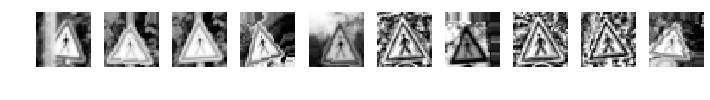

was misclassified as:
Road work :


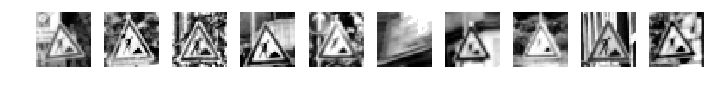

Right-of-way at the next intersection :


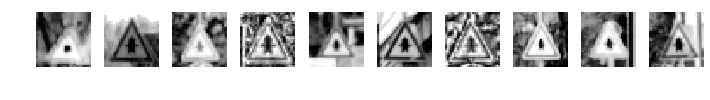

was misclassified as:
Beware of ice/snow :


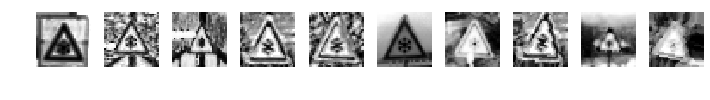

End of no passing by vechiles over 3.5 metric tons :


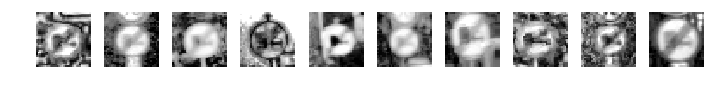

was misclassified as:
End of no passing :


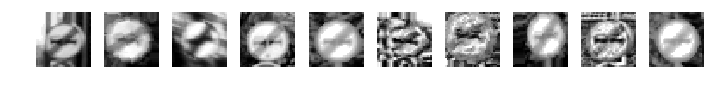

Children crossing :


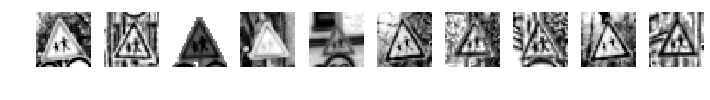

was misclassified as:
Beware of ice/snow :


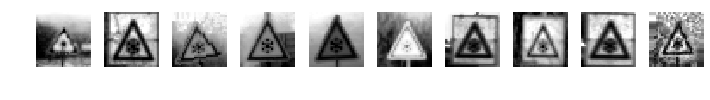

In [72]:

study_range = [27,25,11,30,42,41,28,30]
compare = [1, 0, 1, 0, 1, 0,1,0]
#study_range = [28,30,28,24,28,27]
#compare = [1,0,1,0,1,0]

implot = plt.figure(figsize=(12,4))
counter = 0
for classid in study_range:
    print (class_stats.SignName[classid],':')
    implot = plt.figure(figsize=(12,1))
    X_class = X_train[y_train==classid]
    #rnd_idx = np.random.random(range(len(X_class)), 10)
    rnd_idx=np.random.randint(0, high=len(X_class), size=10)

    for i in range(10):
        ax = implot.add_subplot(1,10,i + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(X_class[rnd_idx[i]].squeeze(),cmap='gray')
    plt.show()
    if compare[counter]:
        print ('was misclassified as:')
    counter += 1

#### Testing  the model on new Images found from WEB

Load the new  images

In [67]:

### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg

# http://electronicimaging.spiedigitallibrary.org/data/journals/electim/927109/jei_22_4_041105_f010.png

#image1 = mpimg.imread('external-data/no-entry.png')

image1 = mpimg.imread('external-data/right-of-way.png')

#plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
#plotter.plot_image(image, 1, 3, 0)

#image2 = mpimg.imread('external-data/right-turn.png')

image2 = mpimg.imread('external-data/pedestrians_1.png')
#print('This image is:', type(image), 'with dimesions:', image.shape)
#plot_image(image, 1, 3, 0)
#actual.append([33, image])
#image3 = mpimg.imread('external-data/20kmph.png')

image3 = mpimg.imread('external-data/general_caution_1.png')
#plot_image(image, 1, 3, 0)
#actual.append([0, image])
#image4 = mpimg.imread('external-data/children-crossing.png')

image4 = mpimg.imread('external-data/children-crossing_1.png')
#plot_image(image, 1, 3, 0)
#actual.append([28, image])
#image5 = mpimg.imread('external-data/stop.png')

image5 = mpimg.imread('external-data/stop.png')
#plot_image(image, 1, 3, 0)
#actual.append([14, image])
#image6 = mpimg.imread('external-data/no-truck-passing.png')

image6 = mpimg.imread('external-data/no-truck-passing.png')
#plot_image(image, 1, 3, 0)
#actual.append([10, image])
X_test_new = [image1, image2, image3, image4, image5, image6]
y_test_new = [11,27,18,28,14,10]

### Preprocess

In [68]:
from skimage import color, exposure, transform

def resize_data(data):
    print(np.asarray(data).shape)
    resize=[]
    # Histogram normalization in v channel
    for img in np.asarray(data):
        #print(img.shape)
        # central square crop
        
        # rescale to standard size
        img = transform.resize(img, (32, 32,3))
        import numpy, itertools


        #for i, j, k in itertools.product(*map(xrange, img.shape)):
        #img[k,i,j] = img [i,j,k]

        # roll color axis to axis 0
        #img = np.rollaxis(img, -1)
        resize.append(img)

    return np.asarray(resize)


#preprocess = reload(preprocess)
X_test_new_orig = np.copy(X_test_new)

#X_test_new = read_all_imgs()
X_test_new = resize_data(X_test_new)
print(X_test_new.shape)


X_test_new= preprocess.conv_to_grayscale_data(np.asarray(X_test_new))
X_test_new = preprocess.hist_equalize(X_test_new)
X_test_new = preprocess.adaptive_equalize(X_test_new)
#X_test_new = preprocess.contrast_stretch(X_test_new)

(6,)


C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(6, 32, 32, 3)


C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\skimage\exposure\exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "
  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 6/6 [00:00<00:00, 50.28it/s]


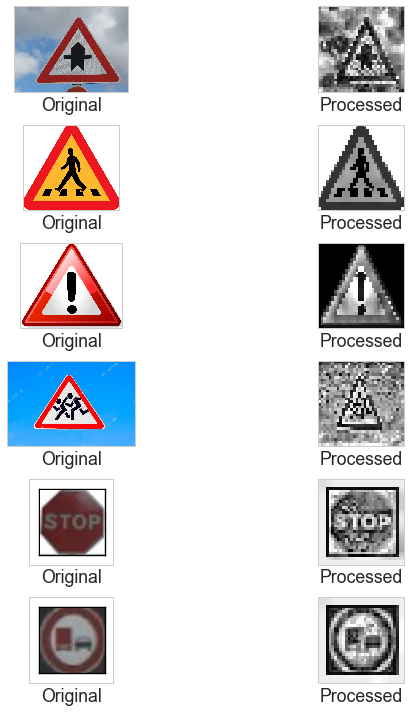

In [69]:
plotter = reload(plotter)
plotter.plot_2_datasets(X_test_new_orig.squeeze(),X_test_new.squeeze(),"Original", "Processed")


Test

In [70]:
prob_new = model.predict(X_test_new)
preds_new = np.argmax(prob_new, axis=1)
print(y_test_new)
print(preds_new)

[11, 27, 18, 28, 14, 10]
[11 27 18 30 14 10]


We see below, class 28 has been wrongly misclassified as class 30
[Childrens Crossing  has been  wrongly misclassified as 'Beware of ICE/SNOW']

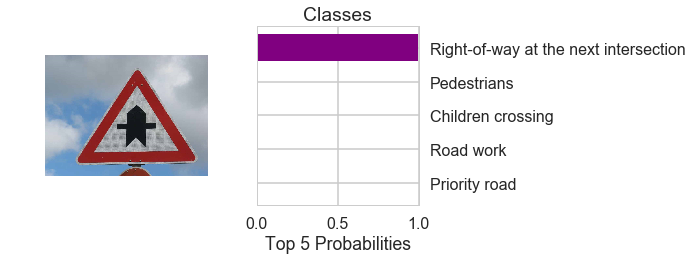

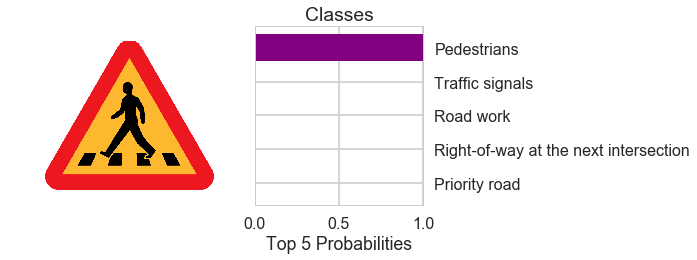

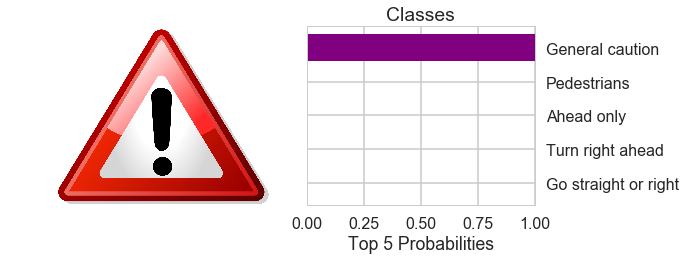

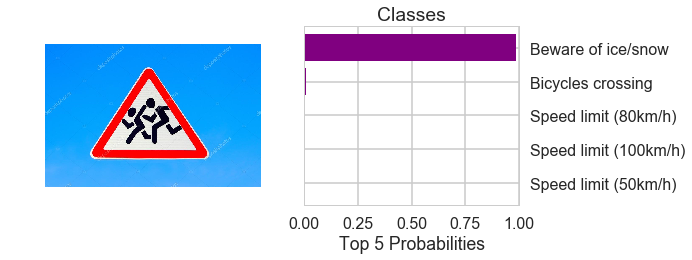

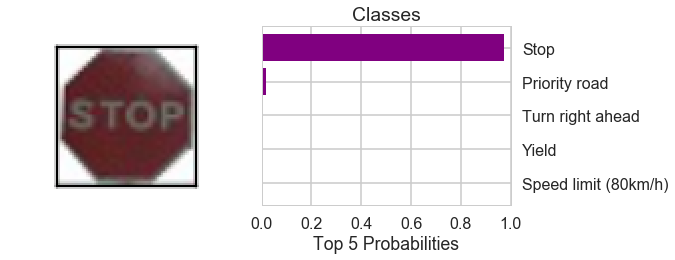

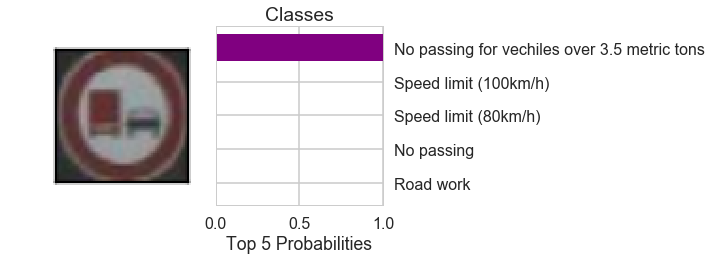

In [103]:
plotter.plot_top_n_preds(X_test_new_orig,prob_new,np.asarray(class_stats.SignName),5)


Children crossing :


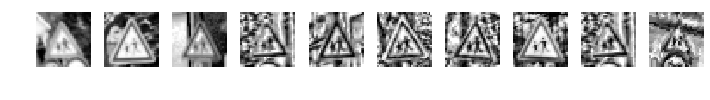

was misclassified as:
Beware of ice/snow :


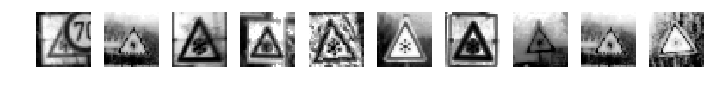

In [74]:

#study_range = [27, 30, 11, 30, 18, 26, 21, 31, 42, 36,28,27]
#compare = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0,1,0]
study_range = [28,30]
compare = [1,0]

implot = plt.figure(figsize=(12,4))
counter = 0
for classid in study_range:
    print (class_stats.SignName[classid],':')
    implot = plt.figure(figsize=(12,1))
    X_class = X_train[y_train==classid]
    #rnd_idx = np.random.random(range(len(X_class)), 10)
    rnd_idx=np.random.randint(0, high=len(X_class), size=10)

    for i in range(10):
        ax = implot.add_subplot(1,10,i + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(X_class[rnd_idx[i]].squeeze(),cmap='gray')
    plt.show()
    if compare[counter]:
        print ('was misclassified as:')
    counter += 1

# Conclusion

* The datasets have been explored, a model proposed, trained, tested, evaluated. 
* The proposed model just falls short of the human accuracy benchmark 98.84 on Test Data[http://benchmark.ini.rub.de/], but meets the benchmark proposed for this project given the limited resources.
